In [20]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
#https://pyramid-arima.readthedocs.io/en/latest/_submodules/arima.html
import numpy
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pyramid.arima import auto_arima

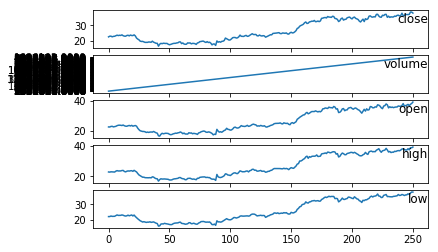

In [21]:
# load dataset
dataset = pandas.read_csv('URBN.csv', header=0, index_col=0)
values = dataset.values[1::, :]
values = numpy.flipud(values)
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pandas.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pandas.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.272072   0.060236   0.269197   0.267930   0.345133  0.291441
2   0.291441   0.053993   0.267873   0.263870   0.349558  0.292793
3   0.292793   0.049257   0.284643   0.272891   0.393805  0.273423
4   0.273423   0.054651   0.287732   0.271087   0.358407  0.286937
5   0.286937   0.061345   0.270962   0.266351   0.362832  0.290090


In [23]:
# split into train and test sets
values = reframed.values
n_train_hours = 170
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 1, 5) (170,) (80, 1, 5) (80,)


In [24]:
train_X.shape[2]

5

In [25]:
# design network
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=15, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 170 samples, validate on 80 samples
Epoch 1/100
 - 1s - loss: 0.1900 - val_loss: 0.5421
Epoch 2/100
 - 0s - loss: 0.0829 - val_loss: 0.2889
Epoch 3/100
 - 0s - loss: 0.0665 - val_loss: 0.1658
Epoch 4/100
 - 0s - loss: 0.0641 - val_loss: 0.1780
Epoch 5/100
 - 0s - loss: 0.0466 - val_loss: 0.1357
Epoch 6/100
 - 0s - loss: 0.0383 - val_loss: 0.0848
Epoch 7/100
 - 0s - loss: 0.0304 - val_loss: 0.0445
Epoch 8/100
 - 0s - loss: 0.0266 - val_loss: 0.0329
Epoch 9/100
 - 0s - loss: 0.0278 - val_loss: 0.0375
Epoch 10/100
 - 0s - loss: 0.0236 - val_loss: 0.0328
Epoch 11/100
 - 0s - loss: 0.0246 - val_loss: 0.0342
Epoch 12/100
 - 0s - loss: 0.0259 - val_loss: 0.0361
Epoch 13/100
 - 0s - loss: 0.0260 - val_loss: 0.0323
Epoch 14/100
 - 0s - loss: 0.0253 - val_loss: 0.0340
Epoch 15/100
 - 0s - loss: 0.0260 - val_loss: 0.0343
Epoch 16/100
 - 0s - loss: 0.0252 - val_loss: 0.0440
Epoch 17/100
 - 0s - loss: 0.0255 - val_loss: 0.0383
Epoch 18/100
 - 0s - loss: 0.0273 - val_loss: 0.0325
Epoch 19/1

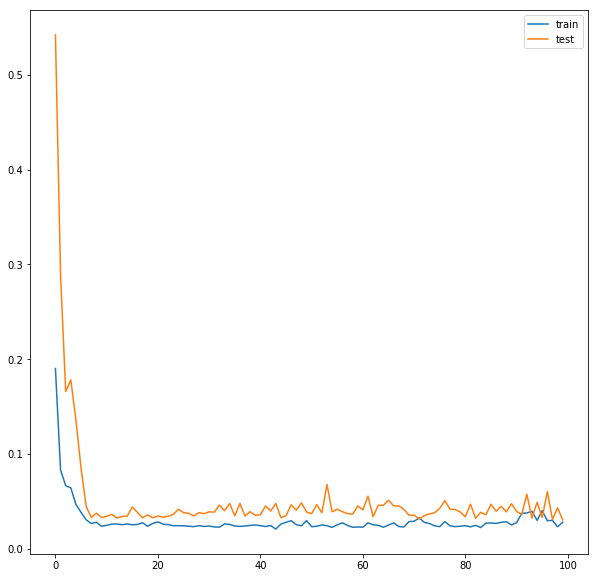

In [26]:
# plot history
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [27]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = numpy.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = numpy.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.873


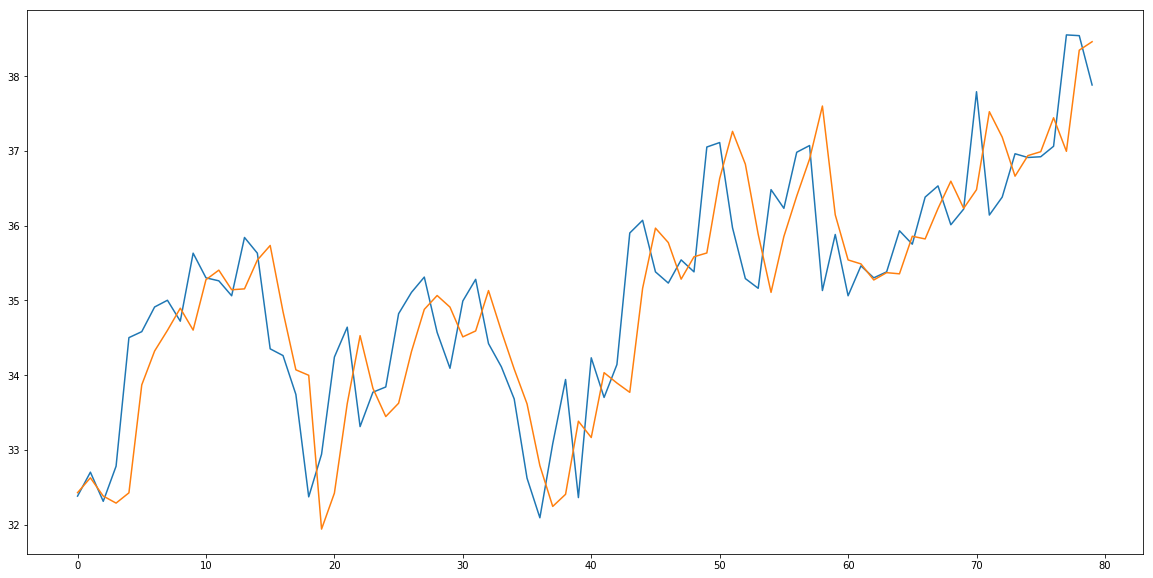

In [28]:
plt.figure(figsize=(20,10))
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

In [29]:
# Test on the whole dataset: prepare data
values2 = reframed.values
train_X2, train_y2 = values2[:, :-1], values2[:, -1]
train_X2 = train_X2.reshape((train_X2.shape[0], 1, train_X2.shape[1]))
print(train_X2.shape, train_y2.shape)

(250, 1, 5) (250,)


In [30]:
# Test o the whole dataset: design network
model2 = Sequential()
model2.add(LSTM(300, input_shape=(train_X2.shape[1], train_X2.shape[2])))
model.add(Dropout(0.3))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(train_X2, train_y2, epochs=100, batch_size=15, verbose=2, shuffle=False)

Epoch 1/100
 - 1s - loss: 0.2650
Epoch 2/100
 - 0s - loss: 0.0861
Epoch 3/100
 - 0s - loss: 0.0982
Epoch 4/100
 - 0s - loss: 0.0721
Epoch 5/100
 - 0s - loss: 0.0440
Epoch 6/100
 - 0s - loss: 0.0309
Epoch 7/100
 - 0s - loss: 0.0283
Epoch 8/100
 - 0s - loss: 0.0283
Epoch 9/100
 - 0s - loss: 0.0286
Epoch 10/100
 - 0s - loss: 0.0289
Epoch 11/100
 - 0s - loss: 0.0283
Epoch 12/100
 - 0s - loss: 0.0286
Epoch 13/100
 - 0s - loss: 0.0292
Epoch 14/100
 - 0s - loss: 0.0287
Epoch 15/100
 - 0s - loss: 0.0287
Epoch 16/100
 - 0s - loss: 0.0294
Epoch 17/100
 - 0s - loss: 0.0294
Epoch 18/100
 - 0s - loss: 0.0294
Epoch 19/100
 - 0s - loss: 0.0286
Epoch 20/100
 - 0s - loss: 0.0294
Epoch 21/100
 - 0s - loss: 0.0299
Epoch 22/100
 - 0s - loss: 0.0280
Epoch 23/100
 - 0s - loss: 0.0281
Epoch 24/100
 - 0s - loss: 0.0296
Epoch 25/100
 - 0s - loss: 0.0290
Epoch 26/100
 - 0s - loss: 0.0272
Epoch 27/100
 - 0s - loss: 0.0276
Epoch 28/100
 - 0s - loss: 0.0304
Epoch 29/100
 - 0s - loss: 0.0304
Epoch 30/100
 - 0s - lo

In [31]:
# make predictions
yhat2 = model2.predict(train_X2)
train_X2 = train_X2.reshape((train_X2.shape[0], train_X2.shape[2]))
inv_yhat2 = numpy.concatenate((yhat2, train_X2[:, 1:]), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]

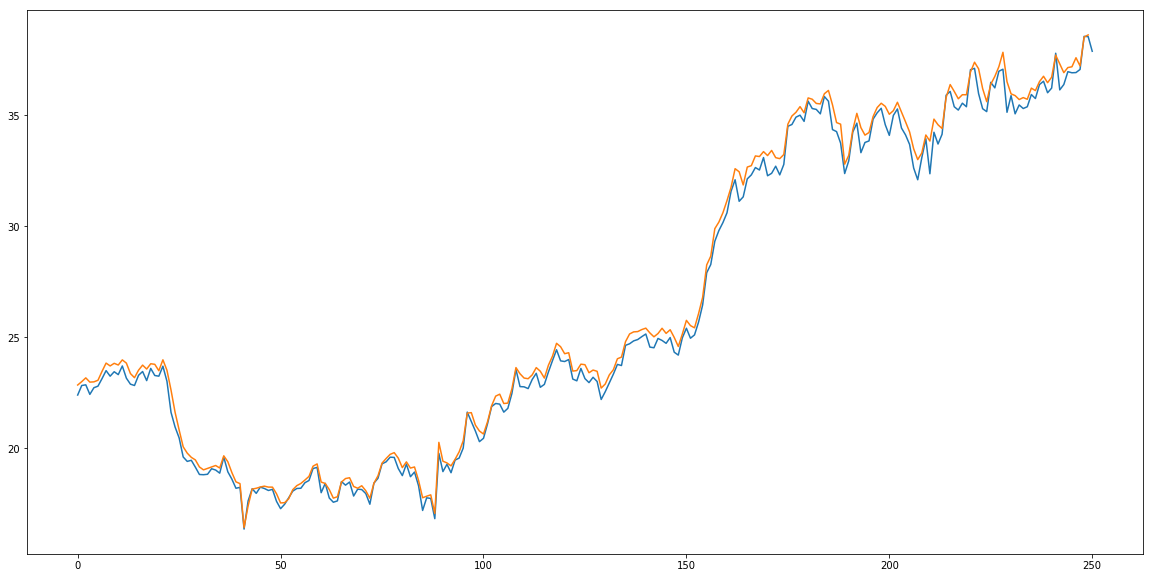

In [32]:
plt.figure(figsize=(20,10))
plt.plot(numpy.flipud(dataset.values[1::, 0]))
plt.plot(inv_yhat2)

In [33]:
numpy.savetxt("LSTM_Predicted.csv", inv_yhat2, delimiter=",")

In [34]:
stepwise_model = auto_arima(inv_yhat2, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=417.959, BIC=435.404, Fit time=3.310 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=534.044, BIC=541.022, Fit time=0.115 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=485.684, BIC=499.640, Fit time=0.341 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=416.055, BIC=430.011, Fit time=0.773 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=416.360, BIC=433.804, Fit time=1.478 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=535.380, BIC=545.847, Fit time=0.136 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=416.298, BIC=433.742, Fit time=2.409 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=417.531, BIC=438.464, Fit time=2.945 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=415.970, BIC=426.437, Fit time=0.492 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 7);

In [35]:
print(stepwise_model.aic())

415.8522454084563


In [36]:
n_periods = 15
future_forecast = stepwise_model.predict(n_periods=n_periods)
print(future_forecast)
trainPredict2full = numpy.append(inv_yhat2,future_forecast)

[38.74901585 38.85707242 38.9331688  39.17903749 39.30921438 39.65686777
 39.80210814 39.9948039  40.09530347 40.18072945 40.41485079 40.60226909
 40.85559463 41.01091051 41.21495303]


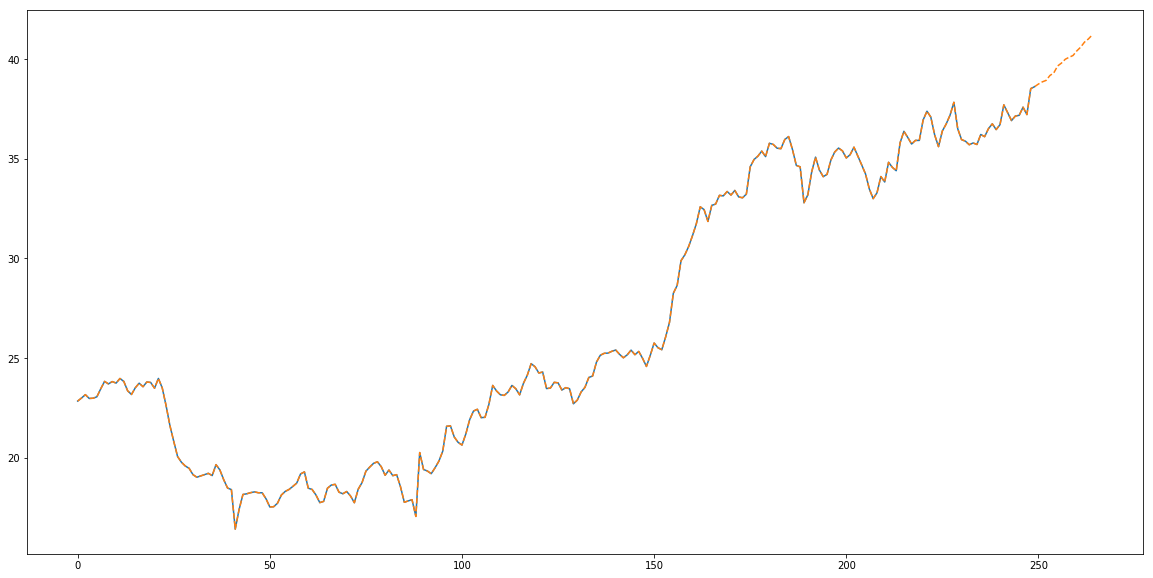

In [37]:
plt.figure(figsize=(20,10))
plt.plot(inv_yhat2)
plt.plot(trainPredict2full, '--')
plt.show()